<a href="https://colab.research.google.com/github/msaantonova/Accent-Classification_Speech-technologies/blob/main/Accent_recognition_project_SS25_(THIS_ONE).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Speech Technologies Project
Anastasiya Saputo, Arina Antonova and Milica Djordjevic

For language recognition we used the CommonVoice 21.0 dataset

for 3 languages:

Russian
Belarusian
Serbian
for 3 languages:
*   **Russian**
*   **Belarusian**
*   **Serbian**

# Dataset

##Installs and Imports

Mounting the Drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Imports and installs

In [ ]:
!pip install -q speechbrain==0.5.13 \
    transformers==4.25.1 \
    librosa==0.9.2 \
    ipdb

In [ ]:
import pandas as pd
import os
import tarfile
import zipfile
import csv
import torch

In [ ]:
import librosa
import soundfile as sf
from tqdm import tqdm

In [ ]:
from sklearn.model_selection import train_test_split

## Serbian

For Serbian, the dataset used is the CommonVoice 21.0 Corpus, because the Delta dataset doesn't have enough samples.

### Loading and analysing the dataset

In [ ]:
# Loading the dataset locally
tar_path = "/content/cv-corpus-21.0-2025-03-14-sr.tar"
extract_path = "/content/cv_data"

with tarfile.open(tar_path, "r") as tar:
    tar.extractall(path=extract_path)

print("Extraction complete.")

Extraction complete.


In [ ]:
data_path = "/content/cv_data/cv-corpus-21.0-2025-03-14/sr"

validated = pd.read_csv(os.path.join(data_path, "validated.tsv"), sep='\t')
other = pd.read_csv(os.path.join(data_path, "other.tsv"), sep='\t')

print(f"Validated samples: {len(validated)}")
print(f"Other samples: {len(other)}")

df_full = pd.concat([validated, other], ignore_index=True)

print(f"Total samples combined: {len(df_full)}")

Validated samples: 6201
Other samples: 4252
Total samples combined: 10453


In [ ]:
data_path = "/content/cv_data/cv-corpus-21.0-2025-03-14/sr"
validated_path = os.path.join(data_path, "validated.tsv")
other_path = os.path.join(data_path, "other.tsv")

df_validated = pd.read_csv(validated_path, sep='\t')
df_other = pd.read_csv(other_path, sep='\t')

df_validated['source'] = 'validated'
df_other['source'] = 'other'

df_combined = pd.concat([df_validated, df_other], ignore_index=True)

print(f"Validated samples: {len(df_validated)}")
print(f"Other samples: {len(df_other)}")
print(f"Total samples combined: {len(df_combined)}")

# 70% train, 15% dev, 15% test
df_train_sr, df_temp_sr = train_test_split(df_combined, test_size=0.3, random_state=42)
df_dev_sr, df_test_sr = train_test_split(df_temp_sr, test_size=0.5, random_state=42)

print(f"Train size serbian: {len(df_train_sr)}")
print(f"Dev size serbian: {len(df_dev_sr)}")
print(f"Test size serbian: {len(df_test_sr)}")

Validated samples: 6201
Other samples: 4252
Total samples combined: 10453
Train size serbian: 7317
Dev size serbian: 1568
Test size serbian: 1568


In [ ]:
df_train_sr.head()

,client_id,path,sentence_id,sentence,sentence_domain,up_votes,down_votes,age,gender,accents,variant,locale,segment,source
3206,8871c9cc7b2845c3c9ada3fdcbe4570d946355312046c8...,common_voice_sr_36950568.mp3,5cbeabb5f1176eca6897f8b8418ecd6b23133789e36e99...,Он је мудра особа.,NaN,4,0,twenties,male_masculine,Južnjački,NaN,sr,NaN,validated
5616,c20cb0c0edb9cd9c40b412766f5b5d9a615df054ef83c7...,common_voice_sr_28441293.mp3,9eb009b7cf6218dd67f768b75dd75ac403eeb5896b1dde...,Зар ме не знате?,NaN,2,0,twenties,female_feminine,NaN,NaN,sr,NaN,validated
1860,4ad3d9184f039ff4d6070ed74e23707ae802e7a5ad545f...,common_voice_sr_39885228.mp3,01d85a691267486104607e391299696ac63e5cc3a1b6b7...,Жене га ипак воле!,NaN,4,0,twenties,NaN,šumajsko-vojvođanski,NaN,sr,NaN,validated
10210,6c24b4121862c2d34414d977ecf9134d1182f7bc686b05...,common_voice_sr_41024500.mp3,ef5510fc02e7234e9608168df23242657cd44f7f1c7b23...,Шта је ваш одговор?,NaN,0,0,sixties,NaN,NaN,NaN,sr,NaN,other
8131,6c24b4121862c2d34414d977ecf9134d1182f7bc686b05...,common_voice_sr_40981980.mp3,c2d823ccf7230fea77f1922518da8f1336c05c81a6f144...,Само молим вас?,NaN,0,0,sixties,NaN,NaN,NaN,sr,NaN,other


In [ ]:
input_wav_dir = '/content/accent-recog-slt2022/CommonAccent/data_small/wav_files'

# Make sure the directory exists
os.makedirs(input_wav_dir, exist_ok=True)

all_wav_files = [f for f in os.listdir(input_wav_dir) if f.endswith('.wav')]
print(f"number of wav files in folder: {len(all_wav_files)}")

number of wav files in folder: 0


### Converting mp3 to wav

In [ ]:
validated_path = '/content/cv_data/cv-corpus-21.0-2025-03-14/sr/validated.tsv'
other_path = '/content/cv_data/cv-corpus-21.0-2025-03-14/sr/other.tsv'

input_mp3_dir = '/content/cv_data/cv-corpus-21.0-2025-03-14/sr/clips'
output_wav_dir = '/content/accent-recog-slt2022/CommonAccent/data_small/wav_files'
os.makedirs(output_wav_dir, exist_ok=True)

df_validated = pd.read_csv(validated_path, sep='\t')
df_other = pd.read_csv(other_path, sep='\t')
df_all = pd.concat([df_validated, df_other], ignore_index=True)

all_paths = df_all['path'].unique()
print(f"Overall unique files for converting: {len(all_paths)}")

existing_files = [f for f in all_paths if os.path.exists(os.path.join(input_mp3_dir, f))]
print(f"Mp3 files exist on disk: {len(existing_files)}")

for file in tqdm(existing_files, desc="Converting MP3 -> WAV"):
    mp3_path = os.path.join(input_mp3_dir, file)
    wav_path = os.path.join(output_wav_dir, file.replace('.mp3', '.wav'))
    try:
        audio, sr = librosa.load(mp3_path, sr=16000, mono=True)
        sf.write(wav_path, audio, 16000)
    except Exception as e:
        print(f"❌ Error {file}: {e}")


Overall unique files for converting: 10453
Mp3 files exist on disk: 10453


Converting MP3 -> WAV: 100%|██████████| 10453/10453 [14:39<00:00, 11.89it/s]


In [ ]:
# Step 1: Collect metadata (optional)
converted_files = []
for file in existing_files:
    wav_file = file.replace('.mp3', '.wav')
    wav_path = os.path.join(output_wav_dir, wav_file)
    if os.path.exists(wav_path):
        converted_files.append(wav_file)

# Save metadata CSV
df_converted = df_all[df_all['path'].isin(existing_files)].copy()
df_converted['path'] = df_converted['path'].apply(lambda x: x.replace('.mp3', '.wav'))
df_converted.to_csv('/content/converted_metadata_sr.csv', index=False)

# Step 2: Zip the output directory
zip_path = '/content/wav_dataset_sr.zip'
with zipfile.ZipFile(zip_path, 'w') as zipf:
    for root, dirs, files in os.walk(output_wav_dir):
        for file in files:
            file_path = os.path.join(root, file)
            arcname = os.path.relpath(file_path, output_wav_dir)
            zipf.write(file_path, arcname=arcname)

print("✅ Zipping complete.")

# Step 3: Create a download link (Google Colab-specific)
#from google.colab import files
#files.download(zip_path)


✅ Zipping complete.


### Creating the train/val/test sets

In [ ]:
validated_path = '/content/cv_data/cv-corpus-21.0-2025-03-14/sr/validated.tsv'
other_path = '/content/cv_data/cv-corpus-21.0-2025-03-14/sr/other.tsv'

df_validated = pd.read_csv(validated_path, sep='\t')
df_other = pd.read_csv(other_path, sep='\t')
df_all = pd.concat([df_validated, df_other], ignore_index=True)

keep_columns = ["path", "sentence", "client_id", "locale"]
df_all = df_all[[col for col in keep_columns if col in df_all.columns]]

wav_dir = '/content/accent-recog-slt2022/CommonAccent/data_small/wav_files'

def build_dataset(split_df, split_name):
    df_split = df_all[df_all["path"].isin(split_df["path"])].copy()

    df_split["path"] = df_split["path"].apply(lambda x: os.path.join(wav_dir, x.replace(".mp3", ".wav")))
    df_split = df_split[df_split["path"].apply(os.path.exists)]
    df_split["path"] = df_split["path"].apply(lambda x: os.path.relpath(x, start="/content"))

    df_split.rename(columns={
        "sentence": "text",
        "client_id": "speaker_id",
        "locale": "language"
    }, inplace=True)

    output_path = f"/content/{split_name}.sr.csv"
    df_split.to_csv(output_path, index=False)
    print(f"✅ {split_name}.sr.csv saved ({len(df_split)}).")

build_dataset(df_train_sr, "train")
build_dataset(df_dev_sr, "val")
build_dataset(df_test_sr, "test")

✅ train.sr.csv saved (7317).
✅ val.sr.csv saved (1568).
✅ test.sr.csv saved (1568).


In [ ]:
pd.read_csv("/content/train.sr.csv").columns

df_train = pd.read_csv("/content/train.sr.csv")
df_train.head()

,path,text,speaker_id,language
0,accent-recog-slt2022/CommonAccent/data_small/w...,Само проширење међутим не представља окончање ...,b85fea5170493896b788360e6850087ed1712480443dde...,sr
1,accent-recog-slt2022/CommonAccent/data_small/w...,"Хенри се оженио и трећи пут, за краљицу изабра...",db9eeb26b34841ed37365a1e92f39b83b58bf8ca9b5242...,sr
2,accent-recog-slt2022/CommonAccent/data_small/w...,Реци и мени!,2d58fc9c2fa8c930ac0542e0b5e3812389045e509cf773...,sr
3,accent-recog-slt2022/CommonAccent/data_small/w...,"Хајде, хајде тамо.",2d58fc9c2fa8c930ac0542e0b5e3812389045e509cf773...,sr
4,accent-recog-slt2022/CommonAccent/data_small/w...,"Донели смо јакне, џемпере, топлију одећу.",4c7c196d5dc5168857ee8adfc2d1bb1f0a47211326ae26...,sr


## Russian

### Loading and analysing the dataset

In [ ]:
# Loading the dataset locally
tar_path = "/content/cv-corpus-21.0-delta-2025-03-14-ru.tar"
extract_path = "/content/cv_data"

with tarfile.open(tar_path, "r") as tar:
    tar.extractall(path=extract_path)

print("Extraction complete.")

Extraction complete.


In [ ]:

data_path = "/content/cv_data/cv-corpus-21.0-delta-2025-03-14/ru"

validated = pd.read_csv(os.path.join(data_path, "validated.tsv"), sep='\t')
other = pd.read_csv(os.path.join(data_path, "other.tsv"), sep='\t')

print(f"Validated samples: {len(validated)}")
print(f"Other samples: {len(other)}")

df_full = pd.concat([validated, other], ignore_index=True)

print(f"Total samples combined: {len(df_full)}")

Validated samples: 90
Other samples: 2940
Total samples combined: 3030


In [ ]:

data_path = "/content/cv_data/cv-corpus-21.0-delta-2025-03-14/ru"
validated_path = os.path.join(data_path, "validated.tsv")
other_path = os.path.join(data_path, "other.tsv")

df_validated = pd.read_csv(validated_path, sep='\t')
df_other = pd.read_csv(other_path, sep='\t')

df_validated['source'] = 'validated'
df_other['source'] = 'other'

df_combined = pd.concat([df_validated, df_other], ignore_index=True)

print(f"Validated samples: {len(df_validated)}")
print(f"Other samples: {len(df_other)}")
print(f"Total samples combined: {len(df_combined)}")

# 70% train, 15% dev, 15% test
df_train_ru, df_temp_ru = train_test_split(df_combined, test_size=0.3, random_state=42)
df_dev_ru, df_test_ru = train_test_split(df_temp_ru, test_size=0.5, random_state=42)

print(f"Train size russian: {len(df_train_ru)}")
print(f"Dev size russian: {len(df_dev_ru)}")
print(f"Test size russian: {len(df_test_ru)}")

Validated samples: 90
Other samples: 2940
Total samples combined: 3030
Train size russian: 2121
Dev size russian: 454
Test size russian: 455


In [ ]:
df_train_ru.head()

,client_id,path,sentence_id,sentence,sentence_domain,up_votes,down_votes,age,gender,accents,variant,locale,segment,source
2546,d3f1f7c923f0522c03e865129fff2650df0b66ec0df81b...,common_voice_ru_42555795.mp3,dcfbc2f243aece89b99bf586adefc2238becf39f23ba60...,В разрабатываемой технологии взаимодействие ме...,NaN,0,0,NaN,NaN,NaN,NaN,ru,NaN,other
279,4a3d198ccac94aa3330809ce2eef552dec6625d1169508...,common_voice_ru_41973269.mp3,5939e5ac0fbe4b50bcf24d90f901e69ee50071e71be68f...,"Под летним небом звезды сверкали, словно алмаз...",NaN,0,0,thirties,NaN,"Georgian accent,Грузинский акцент",NaN,ru,NaN,other
1510,860c378a00fee36eb354361dae39730bfa969c53e99baf...,common_voice_ru_42327869.mp3,dc5309bb107302de9a63d31cfb8255131a5b42b0cc22ae...,Такой механизм применяется для урегулирования ...,NaN,0,0,thirties,male_masculine,NaN,NaN,ru,NaN,other
1553,860c378a00fee36eb354361dae39730bfa969c53e99baf...,common_voice_ru_42405536.mp3,dc7faf98f1e82b2f0e4ea8f8434fa4c63587a2e37045f0...,"Я смотрю, у вас новое назначение.",NaN,0,0,thirties,male_masculine,NaN,NaN,ru,NaN,other
2230,e4571c8ae7d79a96e6f28a3facacdd14a240bd3f246456...,common_voice_ru_42544239.mp3,d93b5579d81cc6b5087215517c8187a9a04b395cade88c...,Трансатлантическая работорговля была особенно ...,NaN,0,0,thirties,NaN,NaN,NaN,ru,NaN,other


In [ ]:
input_wav_dir = '/content/accent-recog-slt2022/CommonAccent/data_small/wav_files'
all_wav_files = [f for f in os.listdir(input_wav_dir) if f.endswith('.wav')]
print(f"All wav files in follder: {len(all_wav_files)}")  #  ~3000



Всего wav в папке: 10453


In [14]:
ru_accents_df = df_train_ru["accents"].dropna()
print(ru_accents_df.value_counts())

accents
Georgian accent,Грузинский акцент    577
русский стандартный                   78
стандартный                           32
Быстрый, точный                        4
Московский акцент, Россия              3
Русский                                3
без акцента                            3
Bielorusso                             2
Name: count, dtype: int64


### Converting MP3 to WAV

In [ ]:

validated_path = '/content/cv_data/cv-corpus-21.0-delta-2025-03-14/ru/validated.tsv'
other_path = '/content/cv_data/cv-corpus-21.0-delta-2025-03-14/ru/other.tsv'

input_mp3_dir = '/content/cv_data/cv-corpus-21.0-delta-2025-03-14/ru/clips'
output_wav_dir = '/content/accent-recog-slt2022/CommonAccent/data_small/wav_files'
os.makedirs(output_wav_dir, exist_ok=True)

df_validated = pd.read_csv(validated_path, sep='\t')
df_other = pd.read_csv(other_path, sep='\t')
df_all = pd.concat([df_validated, df_other], ignore_index=True)

all_paths = df_all['path'].unique()
print(f"Overall unique files for converting: {len(all_paths)}")

existing_files = [f for f in all_paths if os.path.exists(os.path.join(input_mp3_dir, f))]
print(f"Mp3 files exist on disk: {len(existing_files)}")

for file in tqdm(existing_files, desc="Converting MP3 -> WAV"):
    mp3_path = os.path.join(input_mp3_dir, file)
    wav_path = os.path.join(output_wav_dir, file.replace('.mp3', '.wav'))
    try:
        audio, sr = librosa.load(mp3_path, sr=16000, mono=True)
        sf.write(wav_path, audio, 16000)
    except Exception as e:
        print(f"❌ Error {file}: {e}")


Overall unique files for converting: 3030
Mp3 files exist on disk: 3030


Converting MP3 -> WAV: 100%|██████████| 3030/3030 [07:31<00:00,  6.72it/s]


In [ ]:
#import zipfile

#with zipfile.ZipFile("accent-recog-slt2022.zip", 'r') as zip_ref:
#    zip_ref.extractall("/content")


### Creating train/test/val sets

In [ ]:

validated_path = '/content/cv_data/cv-corpus-21.0-delta-2025-03-14/ru/validated.tsv'
other_path = '/content/cv_data/cv-corpus-21.0-delta-2025-03-14/ru/other.tsv'

df_validated = pd.read_csv(validated_path, sep='\t')
df_other = pd.read_csv(other_path, sep='\t')
df_all = pd.concat([df_validated, df_other], ignore_index=True)

keep_columns = ["path", "sentence", "client_id", "locale"]
df_all = df_all[[col for col in keep_columns if col in df_all.columns]]

wav_dir = '/content/accent-recog-slt2022/CommonAccent/data_small/wav_files'

def build_dataset(split_df, split_name):
    df_split = df_all[df_all["path"].isin(split_df["path"])].copy()

    df_split["path"] = df_split["path"].apply(lambda x: os.path.join(wav_dir, x.replace(".mp3", ".wav")))
    df_split = df_split[df_split["path"].apply(os.path.exists)]
    df_split["path"] = df_split["path"].apply(lambda x: os.path.relpath(x, start="/content"))

    df_split.rename(columns={
        "sentence": "text",
        "client_id": "speaker_id",
        "locale": "language"
    }, inplace=True)

    output_path = f"/content/{split_name}.ru.csv"
    df_split.to_csv(output_path, index=False)
    print(f"✅ {split_name}.ru.csv saved ({len(df_split)}).")

build_dataset(df_train_ru, "train")
build_dataset(df_dev_ru, "val")
build_dataset(df_test_ru, "test")

✅ train.ru.csv saved (2121).
✅ val.ru.csv saved (454).
✅ test.ru.csv saved (455).


In [ ]:
pd.read_csv("/content/train.ru.csv").columns


Index(['path', 'text', 'speaker_id', 'language'], dtype='object')

In [ ]:
df_train = pd.read_csv("/content/train.ru.csv")
df_train.head()

,path,text,speaker_id,language
0,accent-recog-slt2022/CommonAccent/data_small/w...,Особенная кошка - любимица всей семьи,4a3d198ccac94aa3330809ce2eef552dec6625d1169508...,ru
1,accent-recog-slt2022/CommonAccent/data_small/w...,"Верный друг всегда поддержит в трудную минуту,...",4a3d198ccac94aa3330809ce2eef552dec6625d1169508...,ru
2,accent-recog-slt2022/CommonAccent/data_small/w...,"Помечтайте о мире, где каждый человек может пр...",4a3d198ccac94aa3330809ce2eef552dec6625d1169508...,ru
3,accent-recog-slt2022/CommonAccent/data_small/w...,Читать текст и пытаться звучать похоже на ориг...,4a3d198ccac94aa3330809ce2eef552dec6625d1169508...,ru
4,accent-recog-slt2022/CommonAccent/data_small/w...,"хотя все знают, что Венгрия подарила миру таки...",4a3d198ccac94aa3330809ce2eef552dec6625d1169508...,ru


## Belarusian

### Loading and analysing the dataset

In [ ]:
gdrive_path = "/content/drive/MyDrive/Colab Notebooks/cv-corpus-21.0-delta-2025-03-14-be.tar.gz" #change to your location on Google Drive - look it up in the directory from the left
#gdrive_path = "/content/drive/MyDrive/Colab Notebooks/cv-corpus-14.0-delta-2023-06-23-be.tar.gz" #a bigger file
extract_path = '/content/cv_data'
import tarfile

with tarfile.open(gdrive_path, "r:gz") as tar:
    tar.extractall(path=extract_path)

print("Extraction complete.")

Extraction complete.


In [ ]:
data_path = "/content/cv_data/cv-corpus-21.0-delta-2025-03-14/be"
#data_path = "/content/cv_data/cv-corpus-14.0-delta-2023-06-23/be"
validated_path = os.path.join(data_path, "validated.tsv")
other_path = os.path.join(data_path, "other.tsv")

df_validated = pd.read_csv(validated_path, sep='\t')
df_other = pd.read_csv(other_path, sep='\t')

df_validated['source'] = 'validated'
df_other['source'] = 'other'

df_combined = pd.concat([df_validated, df_other], ignore_index=True)

print(f"Validated samples: {len(df_validated)}")
print(f"Other samples: {len(df_other)}")
print(f"Total samples combined: {len(df_combined)}\n")

# 70% train, 15% dev, 15% test
df_train_be, df_temp_be = train_test_split(df_combined, test_size=0.3, random_state=42)
df_dev_be, df_test_be = train_test_split(df_temp_be, test_size=0.5, random_state=42)

print(f"Train size belarusian: {len(df_train_be)}")
print(f"Dev size belarusian: {len(df_dev_be)}")
print(f"Test size belarusian: {len(df_test_be)}")

Validated samples: 639
Other samples: 7203
Total samples combined: 7842

Train size belarusian: 5489
Dev size belarusian: 1176
Test size belarusian: 1177


In [ ]:
df_train_be.head()

,client_id,path,sentence_id,sentence,sentence_domain,up_votes,down_votes,age,gender,accents,variant,locale,segment,source
605,94066a18a2f30a5f8c3b1b93908e9bd180797803cee8ce...,common_voice_be_42076166.mp3,b6b5d55f6e367536a6e794e0679d5ee421914d9fe8baa1...,"Да апошняга моманту цяжка было сказаць, хто ст...",NaN,2,0,NaN,NaN,NaN,NaN,be,NaN,validated
3196,659b04f837f6b33da64c1cfd5472c09c5c611dc8dec68f...,common_voice_be_42139499.mp3,b6ffebb4bb1af260ed3c3da87ffdc46b82da959c9e08d4...,"Дзе менавіта, пакуль няма ведама.",NaN,0,0,NaN,NaN,NaN,NaN,be,NaN,other
3779,eb1078ce1c52d7b2a283533cba8fed0042df12e131514f...,common_voice_be_42250413.mp3,b7802586d0187e30f20e7497341dd5ddc6e34cadf47ab9...,Аднак для навучальнага працэсу наяўнасць мален...,NaN,0,0,NaN,NaN,NaN,NaN,be,NaN,other
1468,98da89725e47cf9fd22a756f540a6d33817008d6624b86...,common_voice_be_41974615.mp3,b5fa7dc5a1765f5ea91af9365fe90116edd2e662ad0fed...,"Добра, што мы можам гандляваць ва ўсіх напрамках.",NaN,0,0,NaN,NaN,NaN,NaN,be,NaN,other
5784,659b04f837f6b33da64c1cfd5472c09c5c611dc8dec68f...,common_voice_be_42498438.mp3,b932fcdf2f0126a30008c8c5d9beedbf58e9dd3d8f3c05...,"Ён стаіць амаль у цэнтры райцэнтра, побач прах...",NaN,1,0,NaN,NaN,NaN,NaN,be,NaN,other


In [ ]:
print(df_train_be["accents"])

605     NaN
3196    NaN
3779    NaN
1468    NaN
5784    NaN
       ... 
5226    NaN
5390    NaN
860     NaN
7603    NaN
7270    NaN
Name: accents, Length: 5489, dtype: object


In [ ]:
be_accents_df = df_train_be["accents"].dropna()
print(be_accents_df)

4935        трасянка
416         трасянка
446         трасянка
4704        трасянка
4932        трасянка
            ...     
4933        трасянка
4929        трасянка
5088    Без акцэнту.
4931        трасянка
4659        трасянка
Name: accents, Length: 90, dtype: object


In [ ]:
print(be_accents_df.value_counts())

accents
трасянка        87
Без акцэнту.     3
Name: count, dtype: int64


### Converting mp3 to wav

In [ ]:

input_mp3_dir = '/content/cv_data/cv-corpus-21.0-delta-2025-03-14/be/clips'
output_wav_dir = '/content/accent-recog-slt2022/CommonAccent/data_small/wav_files'
os.makedirs(output_wav_dir, exist_ok=True)

all_files = pd.concat([df_train_be, df_dev_be, df_test_be])["path"].unique()

# Filtering existing files
existing_files = [f for f in all_files if os.path.exists(os.path.join(input_mp3_dir, f))]
print(f"Files from CSV: {len(all_files)}, found: {len(existing_files)}")

# Convverting formats
for file in tqdm(existing_files, desc="Converting MP3 -> WAV"):
    mp3_path = os.path.join(input_mp3_dir, file)
    wav_path = os.path.join(output_wav_dir, file.replace('.mp3', '.wav'))

    try:
        audio, sr = librosa.load(mp3_path, sr=16000, mono=True)
        sf.write(wav_path, audio, 16000)
    except Exception as e:
        print(f"Could not process {file}: {e}")

Files from CSV: 7842, found: 7842


Converting MP3 -> WAV: 100%|██████████| 7842/7842 [17:59<00:00,  7.27it/s]


### Creating train/test/val sets

In [ ]:
import pandas as pd
import os

validated_path = '/content/cv_data/cv-corpus-21.0-delta-2025-03-14/be/validated.tsv'
other_path = '/content/cv_data/cv-corpus-21.0-delta-2025-03-14/be/other.tsv'

df_validated = pd.read_csv(validated_path, sep='\t')
df_other = pd.read_csv(other_path, sep='\t')
df_all = pd.concat([df_validated, df_other], ignore_index=True)

keep_columns = ["path", "sentence", "client_id", "locale"]
df_all = df_all[[col for col in keep_columns if col in df_all.columns]]

output_wav_dir = '/content/accent-recog-slt2022/CommonAccent/data_small/wav_files'

def build_dataset(split_df, split_name):
    df_split = df_all[df_all["path"].isin(split_df["path"])].copy()

    df_split["path"] = df_split["path"].apply(lambda x: os.path.join(output_wav_dir, x.replace(".mp3", ".wav")))
    df_split = df_split[df_split["path"].apply(os.path.exists)]
    df_split["path"] = df_split["path"].apply(lambda x: os.path.relpath(x, start="/content"))

    df_split.rename(columns={
        "sentence": "text",
        "client_id": "speaker_id",
        "locale": "language"
    }, inplace=True)

    output_path = f"/content/{split_name}.be2.csv"
    df_split.to_csv(output_path, index=False)
    print(f"{split_name}.be2.csv saved ({len(df_split)}).")

build_dataset(df_train_be, "train")
build_dataset(df_dev_be, "val")
build_dataset(df_test_be, "test")

train.be2.csv saved (5489).
val.be2.csv saved (1176).
test.be2.csv saved (1177).


In [ ]:
import pandas as pd

# Load the datasets
df_train = pd.read_csv("/content/train.be2.csv")
df_val = pd.read_csv("/content/val.be2.csv")
df_test = pd.read_csv("/content/test.be2.csv")

print("Train:")
df_train.head()

Train:


,path,text,speaker_id,language
0,accent-recog-slt2022/CommonAccent/data_small/w...,"Прасцей кажучы, пустыя паліцы, рост коштаў і г...",1fae492f6bb5d39df233deca5189c444033e2653aecc51...,be
1,accent-recog-slt2022/CommonAccent/data_small/w...,Бабулі ж і ўпрочкі бегаць не было куды.,4395656b63879aa58eff64fe74ccb6a892a4af39c274dd...,be
2,accent-recog-slt2022/CommonAccent/data_small/w...,На што вам ведаць пра што гэты спектакль?,964253dda7b98805d78fcc2a24cef3c53b5e2b53a4c89f...,be
3,accent-recog-slt2022/CommonAccent/data_small/w...,Панскіх яблыкаў табе шкода?,9e2592f21f4f711c38affd76643d43a64128fa51609be4...,be
4,accent-recog-slt2022/CommonAccent/data_small/w...,Пры некіравальным спуску судна перамяшчаецца п...,a133c0323e3032e2b1aede8a367c31f59cdc6601abfaf6...,be


## Merging smaller datasets into one

In [ ]:
!zip -r /content/data_small.zip /content/accent-recog-slt2022/CommonAccent/data_small

#from google.colab import files
#files.download("/content/data_small.zip")

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
  adding: content/accent-recog-slt2022/CommonAccent/data_small/wav_files/common_voice_sr_40471735.wav (deflated 28%)
  adding: content/accent-recog-slt2022/CommonAccent/data_small/wav_files/common_voice_be_42099657.wav (deflated 49%)
  adding: content/accent-recog-slt2022/CommonAccent/data_small/wav_files/common_voice_sr_40977051.wav (deflated 35%)
  adding: content/accent-recog-slt2022/CommonAccent/data_small/wav_files/common_voice_be_41956953.wav (deflated 32%)
  adding: content/accent-recog-slt2022/CommonAccent/data_small/wav_files/common_voice_sr_40997407.wav (deflated 20%)
  adding: content/accent-recog-slt2022/CommonAccent/data_small/wav_files/common_voice_sr_28623205.wav (deflated 26%)
  adding: content/accent-recog-slt2022/CommonAccent/data_small/wav_files/common_voice_sr_40978693.wav (deflated 31%)
  adding: content/accent-recog-slt2022/CommonAccent/data_small/wav_files/common_voice_sr_28216693.wav (deflated 64

In [ ]:
!cp -R /content/accent-recog-slt2022/CommonAccent/data_small/wav_files /content/drive/MyDrive/.../data/wav

cp: cannot create directory '/content/drive/MyDrive/.../data/wav': No such file or directory


Unfortunatlelly, the scripts doen ot have an option for our chosen langauge, so we decided to focus on just langauge recognition of Russian, Belarusian and Serbian

## Balancing the set DO WE NEED THIS?
it's something i added to try it with the balanced set, if we dont need it, i will delete it. i could maybe run it just to see if the results will be different, i had no energy to do it now, i will fall asleep waiting for it 😅

In [ ]:
import os
os.listdir('/content')

['.config',
 'converted_metadata_sr.csv',
 'wav_dataset_sr.zip',
 'cv-corpus-21.0-2025-03-14-sr.tar',
 'train.sr.csv',
 'train.ru.csv',
 'test.be2.csv',
 'val.be2.csv',
 'val.ru.csv',
 'val.sr.csv',
 'cv_data',
 'train.be2.csv',
 'test.sr.csv',
 'cv-corpus-21.0-delta-2025-03-14-ru.tar',
 'test.ru.csv',
 'data_small.zip',
 'drive',
 'accent-recog-slt2022',
 'cv-corpus-21.0-delta-2025-03-14-be.tar',
 'data_all_columns',
 'sample_data']

In [ ]:
import pandas as pd
import os

file_names = [
    'train.ru.csv', 'train.be2.csv', 'train.sr.csv',
    'val.ru.csv', 'val.be2.csv', 'val.sr.csv',
    'test.ru.csv', 'test.be2.csv', 'test.sr.csv'
]

for file in file_names:
    path = f'/content/{file}'
    try:
        df = pd.read_csv(path)
        print(f"{file}: {len(df)} rows")
    except Exception as e:
        print(f"{file}: Error loading file -> {e}")


train.ru.csv: 2121 rows
train.be2.csv: 5489 rows
train.sr.csv: 7317 rows
val.ru.csv: 454 rows
val.be2.csv: 1176 rows
val.sr.csv: 1568 rows
test.ru.csv: 455 rows
test.be2.csv: 1177 rows
test.sr.csv: 1568 rows


In [ ]:
import pandas as pd

# Load all files
train_ru = pd.read_csv('/content/train.ru.csv')
train_be = pd.read_csv('/content/train.be2.csv')
train_sr = pd.read_csv('/content/train.sr.csv')

val_ru = pd.read_csv('/content/val.ru.csv')
val_be = pd.read_csv('/content/val.be2.csv')
val_sr = pd.read_csv('/content/val.sr.csv')

test_ru = pd.read_csv('/content/test.ru.csv')
test_be = pd.read_csv('/content/test.be2.csv')
test_sr = pd.read_csv('/content/test.sr.csv')

# Tag with language (optional, but useful)
for df, lang in zip(
    [train_ru, train_be, train_sr, val_ru, val_be, val_sr, test_ru, test_be, test_sr],
    ['ru', 'be', 'sr'] * 3
):
    df['language'] = lang

# Balance by sampling
train_all = pd.concat([
    train_ru.sample(2121, random_state=42),
    train_be.sample(2121, random_state=42),
    train_sr.sample(2121, random_state=42)
])

val_all = pd.concat([
    val_ru.sample(454, random_state=42),
    val_be.sample(454, random_state=42),
    val_sr.sample(454, random_state=42)
])

test_all = pd.concat([
    test_ru.sample(455, random_state=42),
    test_be.sample(455, random_state=42),
    test_sr.sample(455, random_state=42)
])

# Save combined CSVs
train_all.to_csv('/content/train_all.csv', index=False)
val_all.to_csv('/content/val_all.csv', index=False)
test_all.to_csv('/content/test_all.csv', index=False)

print("✅ Balanced CSV files saved!")


✅ Balanced CSV files saved!


## Creating a common dataset (be + ru + ser)

I have deleted code for balancing because we don't need it. Instead we need to combine our train/test/val sets, so that we coul train the model in the next step.

My russian CSVs contain the following: path, text, speaker_id, language


In [ ]:
import os
import pandas as pd

base_path = "/content"

df_train_ru = pd.read_csv("/content/train.ru.csv")
df_val_ru = pd.read_csv("/content/val.ru.csv")
df_test_ru = pd.read_csv("/content/test.ru.csv")

df_train_be = pd.read_csv(os.path.join(base_path, "train.be2.csv"))
df_val_be = pd.read_csv(os.path.join(base_path, "val.be2.csv"))
df_test_be = pd.read_csv(os.path.join(base_path, "test.be2.csv"))

df_train_sr = pd.read_csv(os.path.join(base_path, "train.sr.csv"))
df_val_sr = pd.read_csv(os.path.join(base_path, "val.sr.csv"))
df_test_sr = pd.read_csv(os.path.join(base_path, "test.sr.csv"))


In [ ]:
df_train_all = pd.concat([df_train_ru, df_train_be, df_train_sr], ignore_index=True)
df_val_all = pd.concat([df_val_ru, df_val_be, df_val_sr], ignore_index=True)
df_test_all = pd.concat([df_test_ru, df_test_be, df_test_sr], ignore_index=True)

#df_train_all = pd.concat([df_train_ru, df_train_be], ignore_index=True)
#df_val_all = pd.concat([df_val_ru, df_val_be], ignore_index=True)
#df_test_all = pd.concat([df_test_ru, df_test_be], ignore_index=True)


In [ ]:
output_path = "/content/data_all"

os.makedirs(output_path, exist_ok=True)

df_train_all.to_csv(os.path.join(output_path, "train_all.csv"), index=False)
df_val_all.to_csv(os.path.join(output_path, "val_all.csv"), index=False)
df_test_all.to_csv(os.path.join(output_path, "test_all.csv"), index=False)

print("✅ All CSVs are combined and saved")


✅ All CSVs are combined and saved


In [ ]:
lang = df_train_all["language"].dropna()

lang_counts = lang.value_counts()

print(lang_counts)

language
sr    7317
be    5489
ru    2121
Name: count, dtype: int64


In [ ]:
df_train_all.head()

,path,text,speaker_id,language
0,accent-recog-slt2022/CommonAccent/data_small/w...,Особенная кошка - любимица всей семьи,4a3d198ccac94aa3330809ce2eef552dec6625d1169508...,ru
1,accent-recog-slt2022/CommonAccent/data_small/w...,"Верный друг всегда поддержит в трудную минуту,...",4a3d198ccac94aa3330809ce2eef552dec6625d1169508...,ru
2,accent-recog-slt2022/CommonAccent/data_small/w...,"Помечтайте о мире, где каждый человек может пр...",4a3d198ccac94aa3330809ce2eef552dec6625d1169508...,ru
3,accent-recog-slt2022/CommonAccent/data_small/w...,Читать текст и пытаться звучать похоже на ориг...,4a3d198ccac94aa3330809ce2eef552dec6625d1169508...,ru
4,accent-recog-slt2022/CommonAccent/data_small/w...,"хотя все знают, что Венгрия подарила миру таки...",4a3d198ccac94aa3330809ce2eef552dec6625d1169508...,ru


DO WE NEED THIS? i dont fully understand what is happening here and i didnt use the cell when training...

In [ ]:
import zipfile
import os

zip_path = "/content/data_small.zip"
temp_extract_path = "/content/temp_data_small_be"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(temp_extract_path)


zip_path = "/content/accent-recog-slt2022/CommonAccent/data_small/wav_files.zip"
temp_extract_path = "/content/temp_data_small_ru"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
  zip_ref.extractall(temp_extract_path)

zip_path = "/content/wav_dataset_sr.zip"
temp_extract_path = "/content/temp_data_small_sr"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
  zip_ref.extractall(temp_extract_path)

FileNotFoundError: [Errno 2] No such file or directory: '/content/accent-recog-slt2022/CommonAccent/data_small/wav_files.zip'

In [ ]:

import shutil

ru_wav_dir = "/content/temp_data_small_ru/content/accent-recog-slt2022/CommonAccent/data_small/wav_files"
be_wav_dir = "/content/temp_data_small_be/content/accent-recog-slt2022/CommonAccent/data_small/wav_files"

combined_wav_dir = "/content/data_all/wav_files"
os.makedirs(combined_wav_dir, exist_ok=True)

def copy_wavs(src_dir, dst_dir):
    copied = 0
    for fname in os.listdir(src_dir):
        src_path = os.path.join(src_dir, fname)
        dst_path = os.path.join(dst_dir, fname)
        if not os.path.exists(dst_path):
            shutil.copy2(src_path, dst_path)
            copied += 1
    return copied

ru_copied = copy_wavs(ru_wav_dir, combined_wav_dir)
be_copied = copy_wavs(be_wav_dir, combined_wav_dir)

print(f"✅ Copied {ru_copied} russian and {be_copied} belorusian audiofiles in {combined_wav_dir}")



FileNotFoundError: [Errno 2] No such file or directory: '/content/temp_data_small_ru/content/accent-recog-slt2022/CommonAccent/data_small/wav_files'

In [ ]:
!zip -r /content/wav_files.zip /content/accent-recog-slt2022/CommonAccent/data_small/wav_files


Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
  adding: content/accent-recog-slt2022/CommonAccent/data_small/wav_files/common_voice_sr_40471735.wav (deflated 28%)
  adding: content/accent-recog-slt2022/CommonAccent/data_small/wav_files/common_voice_be_42099657.wav (deflated 49%)
  adding: content/accent-recog-slt2022/CommonAccent/data_small/wav_files/common_voice_sr_40977051.wav (deflated 35%)
  adding: content/accent-recog-slt2022/CommonAccent/data_small/wav_files/common_voice_be_41956953.wav (deflated 32%)
  adding: content/accent-recog-slt2022/CommonAccent/data_small/wav_files/common_voice_sr_40997407.wav (deflated 20%)
  adding: content/accent-recog-slt2022/CommonAccent/data_small/wav_files/common_voice_sr_28623205.wav (deflated 26%)
  adding: content/accent-recog-slt2022/CommonAccent/data_small/wav_files/common_voice_sr_40978693.wav (deflated 31%)
  adding: content/accent-recog-slt2022/CommonAccent/data_small/wav_files/common_voice_sr_28216693.wav (deflated 64

In [ ]:
from google.colab import files
files.download('/content/wav_files.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Training

## Installs and imports

In [ ]:
!pip install -q pandas==2.2.2 \
    huggingface_hub>=0.7.0 \
    hyperpyyaml==0.0.1 \
    joblib \
    numpy==2.0.2 \
    packaging \
    pre-commit==2.3.0 \
    sentencepiece>=0.1.91 \
    SoundFile \
    tqdm

!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [ ]:
!pip install -q speechbrain pandas librosa soundfile

In [ ]:
import csv
import os
import soundfile as sf
import sys

In [ ]:
import torch
import torchaudio
import pandas as pd
import speechbrain as sb
from speechbrain import Brain
from speechbrain.dataio.dataset import DynamicItemDataset
from speechbrain.dataio.encoder import CategoricalEncoder
from speechbrain.lobes.models.Xvector import Xvector
from speechbrain.nnet.linear import Linear
from speechbrain.processing.features import STFT, Filterbank, InputNormalization

## Training

### DO WE NEED THIS?

DO WE NEED THIS? "this" being the following 20-ish cells. once i run it, it basically cleans the created files and make them blanc, thus making the training unsuccessful. I skipped it when training and think we should maybe delete it

In [ ]:
def update_csv_with_full_path_and_duration(input_csv_path, output_csv_path, base_audio_path):
    import csv
    import os
    import soundfile as sf
    import librosa
    import numpy as np

    modified_rows = []

    with open(input_csv_path, mode='r', newline='', encoding='utf-8') as infile:
        reader = csv.DictReader(infile)
        fieldnames = reader.fieldnames

        wav_key = None
        for key in reader.fieldnames:
            if 'wav' in key.lower() or 'path' in key.lower() or 'file' in key.lower():
                wav_key = key
                break

        if wav_key is None:
            raise ValueError("❌ Audio name not found. Make sure there is a column 'wav' or 'path'.")

        for row in reader:
            try:
                filename = os.path.basename(row[wav_key]).replace('.mp3', '.wav')
                audio_path = os.path.join(base_audio_path, filename)
                data, sr = sf.read(audio_path)
                duration = np.round(librosa.get_duration(y=data, sr=sr), 3)
                row['duration'] = duration
                row[wav_key] = audio_path
                modified_rows.append(row)
            except Exception as e:
                print(f"❌ Failed: {row.get(wav_key, 'N/A')}: {e}")

    with open(output_csv_path, mode='w', newline='', encoding='utf-8') as outfile:
        writer = csv.DictWriter(outfile, fieldnames=fieldnames + ['duration'])
        writer.writeheader()
        writer.writerows(modified_rows)




In [ ]:

csv.field_size_limit(sys.maxsize)

base_audio_path = '/content/data_all/wav_files'

update_csv_with_full_path_and_duration('/content/data_all/train_all.csv', '/content/train_updated.csv', base_audio_path)
update_csv_with_full_path_and_duration('/content/data_all/val_all.csv',   '/content/dev_updated.csv',   base_audio_path)
update_csv_with_full_path_and_duration('/content/data_all/test_all.csv',  '/content/test_updated.csv',  base_audio_path)


Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
❌ Failed: accent-recog-slt2022/CommonAccent/data_small/wav_files/common_voice_be_42527036.wav: Error opening '/content/data_all/wav_files/common_voice_be_42527036.wav': System error.
❌ Failed: accent-recog-slt2022/CommonAccent/data_small/wav_files/common_voice_be_42527039.wav: Error opening '/content/data_all/wav_files/common_voice_be_42527039.wav': System error.
❌ Failed: accent-recog-slt2022/CommonAccent/data_small/wav_files/common_voice_be_42527041.wav: Error opening '/content/data_all/wav_files/common_voice_be_42527041.wav': System error.
❌ Failed: accent-recog-slt2022/CommonAccent/data_small/wav_files/common_voice_be_42527053.wav: Error opening '/content/data_all/wav_files/common_voice_be_42527053.wav': System error.
❌ Failed: accent-recog-slt2022/CommonAccent/data_small/wav_files/common_voice_be_42527066.wav: Error opening '/content/data_all/wav_files/common_voice_be_42527066.wav': System error.
❌ Failed: accent-r

In [ ]:
pd.read_csv('/content/train_updated.csv').head()


FileNotFoundError: [Errno 2] No such file or directory: '/content/train_updated.csv'

In [ ]:
!pip install -q speechbrain pandas librosa soundfile


In [ ]:
import pandas as pd

for fname in ['train_updated.csv', 'dev_updated.csv', 'test_updated.csv']:
    df = pd.read_csv(f'/content/{fname}')
    df['ID'] = df.index.astype(str)  # create ID
    df.to_csv(f'/content/{fname}', index=False)

In [ ]:
import pandas as pd

for fname in ['train_all.csv', 'val_all.csv', 'test_all.csv']:
    df = pd.read_csv(f'/content/{fname}')
    df['ID'] = df.index.astype(str)  # create ID
    df.to_csv(f'/content/{fname}', index=False)

In [ ]:
import pandas as pd
import os

# Loading data
train_df = pd.read_csv('/content/train_updated.csv')
valid_df = pd.read_csv('/content/dev_updated.csv')
test_df  = pd.read_csv('/content/test_updated.csv')

# Check the structure
print(train_df.columns)
print(train_df.head())


Index(['path', 'text', 'speaker_id', 'language', 'duration', 'ID'], dtype='object')
Empty DataFrame
Columns: [path, text, speaker_id, language, duration, ID]
Index: []


In [ ]:
import pandas as pd

for fname in ['train_all.csv', 'val_all.csv', 'test_all.csv']:
    df = pd.read_csv(f'/content/{fname}')
    df['ID'] = df.index.astype(str)  # create ID
    df.to_csv(f'/content/{fname}', index=False)

In [ ]:
!pip install -q speechbrain pandas librosa soundfile torchaudio


In [ ]:
import sys
print([p for p in sys.path])
import os
print(os.listdir('.'))


['/content', '/env/python', '/usr/lib/python311.zip', '/usr/lib/python3.11', '/usr/lib/python3.11/lib-dynload', '', '/usr/local/lib/python3.11/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.11/dist-packages/IPython/extensions', '/usr/local/lib/python3.11/dist-packages/setuptools/_vendor', '/root/.ipython', '/tmp/tmpo_darmvg']
['.config', 'converted_metadata_sr.csv', 'wav_dataset_sr.zip', 'cv-corpus-21.0-2025-03-14-sr.tar', 'train.sr.csv', 'train.ru.csv', '=0.7.0', 'test.be2.csv', 'data_all', 'test_updated.csv', 'val.be2.csv', 'val.ru.csv', 'val.sr.csv', 'val_all.csv', 'cv_data', 'train.be2.csv', 'test_all.csv', 'test.sr.csv', 'cv-corpus-21.0-delta-2025-03-14-ru.tar', 'test.ru.csv', 'data_small.zip', 'dev_updated.csv', 'train_updated.csv', 'train_all.csv', 'wav_files.zip', 'drive', '=0.1.91', 'accent-recog-slt2022', 'cv-corpus-21.0-delta-2025-03-14-be.tar', 'data_all_columns', 'sample_data']


In [ ]:
#import importlib.util
#spec = importlib.util.find_spec("torchaudio")
#print(spec.origin)


/usr/local/lib/python3.11/dist-packages/torchaudio/__init__.py


In [ ]:
#pip uninstall torchaudio -y


Found existing installation: torchaudio 2.6.0+cu124
Uninstalling torchaudio-2.6.0+cu124:
  Successfully uninstalled torchaudio-2.6.0+cu124


In [ ]:
#pip install torch torchaudio --upgrade --force-reinstall


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.2/821.2 MB 799.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 66.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.6/216.6 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8/156.8 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20

In [ ]:
#import torchaudio
#print(torchaudio.__version__)
#print(torchaudio.lib._torchaudio)


2.7.1+cu126
<module 'torchaudio.lib._torchaudio' from '/usr/local/lib/python3.11/dist-packages/torchaudio/lib/_torchaudio.so'>


In [ ]:

CSV_TRAIN = "/content/train_updated.csv"
CSV_VALID = "/content/dev_updated.csv"
CSV_TEST  = "/content/test_updated.csv"

sample_rate = 16000
n_mels = 40
num_languages = 3  # be, ru, sr

lang_encoder = CategoricalEncoder()
lang_encoder.update_from_iterable(["be", "ru", "sr"])

def audio_pipeline(path, max_len=48000):
    sig, fs = torchaudio.load(path)
    sig = sig.squeeze(0)
    if sig.shape[0] > max_len:
        sig = sig[:max_len]
    else:
        sig = torch.nn.functional.pad(sig, (0, max_len - sig.shape[0]))
    return sig

def prepare_dataset(csv_path):
    dataset = DynamicItemDataset.from_csv(csv_path)
    dataset.add_dynamic_item(audio_pipeline, takes=["path"], provides=["sig"])

    def encode_language(language):
        return lang_encoder.encode_label(language)

    dataset.add_dynamic_item(encode_language, takes=["language"], provides=["lang_encoded"])
    dataset.set_output_keys(["sig", "lang_encoded"])
    return dataset

train_data = prepare_dataset(CSV_TRAIN)
valid_data = prepare_dataset(CSV_VALID)
test_data  = prepare_dataset(CSV_TEST)

compute_STFT = STFT(sample_rate=sample_rate)
compute_fbanks = Filterbank(n_mels=n_mels)
normalize = InputNormalization()

embedding_model = Xvector()

import torch
import torch.nn as nn

class StatsPooling(nn.Module):
    def forward(self, x):
        mean = x.mean(dim=2)
        std = x.std(dim=2)
        return torch.cat((mean, std), dim=1)

class FixedXvector(nn.Module):
    def __init__(self):
        super().__init__()
        self.tdnn1 = nn.Conv1d(40, 512, kernel_size=5, stride=1, padding=2)
        self.relu = nn.ReLU()
        self.tdnn2 = nn.Conv1d(512, 512, kernel_size=3, stride=1, padding=1)
        self.tdnn3 = nn.Conv1d(512, 512, kernel_size=3, stride=1, padding=1)
        self.tdnn4 = nn.Conv1d(512, 512, kernel_size=1)
        self.tdnn5 = nn.Conv1d(512, 1500, kernel_size=1)
        self.stats_pooling = StatsPooling()
        self.fc1 = nn.Linear(3000, 512)

    def forward(self, x):
        x = self.relu(self.tdnn1(x))
        x = self.relu(self.tdnn2(x))
        x = self.relu(self.tdnn3(x))
        x = self.relu(self.tdnn4(x))
        x = self.relu(self.tdnn5(x))
        x = self.stats_pooling(x)
        x = self.fc1(x)
        return x

modules = {
    "compute_STFT": compute_STFT,
    "compute_fbanks": compute_fbanks,
    "normalize": normalize,
    "embedding_model": FixedXvector(),
    "classifier": Linear(input_size=512, n_neurons=num_languages),
}


hparams = {
    "sample_rate": sample_rate,
    "n_mels": n_mels,
    "compute_cost": torch.nn.functional.cross_entropy,
    "batch_size": 8,
    "train_loader": train_data,
}

IndexError: list index out of range

OK, up until now, we can either delete the cells form the last DO WE NEED THIS to HERE, or leave them be as a lesson/show of what didnt work

### Part that worked

In [ ]:

CSV_TRAIN = "/content/train_all.csv"
CSV_VALID = "/content/val_all.csv"
CSV_TEST  = "/content/test_all.csv"

sample_rate = 16000
n_mels = 40
num_languages = 3  # be, ru, sr

lang_encoder = CategoricalEncoder()
lang_encoder.update_from_iterable(["be", "ru", "sr"])

def audio_pipeline(path, max_len=48000):
    sig, fs = torchaudio.load(path)
    sig = sig.squeeze(0)
    if sig.shape[0] > max_len:
        sig = sig[:max_len]
    else:
        sig = torch.nn.functional.pad(sig, (0, max_len - sig.shape[0]))
    return sig

def prepare_dataset(csv_path):
    dataset = DynamicItemDataset.from_csv(csv_path)
    dataset.add_dynamic_item(audio_pipeline, takes=["path"], provides=["sig"])

    def encode_language(language):
        return lang_encoder.encode_label(language)

    dataset.add_dynamic_item(encode_language, takes=["language"], provides=["lang_encoded"])
    dataset.set_output_keys(["sig", "lang_encoded"])
    return dataset

train_data = prepare_dataset(CSV_TRAIN)
valid_data = prepare_dataset(CSV_VALID)
test_data  = prepare_dataset(CSV_TEST)

compute_STFT = STFT(sample_rate=sample_rate)
compute_fbanks = Filterbank(n_mels=n_mels)
normalize = InputNormalization()

embedding_model = Xvector()

import torch
import torch.nn as nn

class StatsPooling(nn.Module):
    def forward(self, x):
        mean = x.mean(dim=2)
        std = x.std(dim=2)
        return torch.cat((mean, std), dim=1)

class FixedXvector(nn.Module):
    def __init__(self):
        super().__init__()
        self.tdnn1 = nn.Conv1d(40, 512, kernel_size=5, stride=1, padding=2)
        self.relu = nn.ReLU()
        self.tdnn2 = nn.Conv1d(512, 512, kernel_size=3, stride=1, padding=1)
        self.tdnn3 = nn.Conv1d(512, 512, kernel_size=3, stride=1, padding=1)
        self.tdnn4 = nn.Conv1d(512, 512, kernel_size=1)
        self.tdnn5 = nn.Conv1d(512, 1500, kernel_size=1)
        self.stats_pooling = StatsPooling()
        self.fc1 = nn.Linear(3000, 512)

    def forward(self, x):
        x = self.relu(self.tdnn1(x))
        x = self.relu(self.tdnn2(x))
        x = self.relu(self.tdnn3(x))
        x = self.relu(self.tdnn4(x))
        x = self.relu(self.tdnn5(x))
        x = self.stats_pooling(x)
        x = self.fc1(x)
        return x

modules = {
    "compute_STFT": compute_STFT,
    "compute_fbanks": compute_fbanks,
    "normalize": normalize,
    "embedding_model": FixedXvector(),
    "classifier": Linear(input_size=512, n_neurons=num_languages),
}


hparams = {
    "sample_rate": sample_rate,
    "n_mels": n_mels,
    "compute_cost": torch.nn.functional.cross_entropy,
    "batch_size": 8,
    "train_loader": train_data,
}

In [ ]:
# Class Brain
class LangIDBrain(sb.Brain):
    def compute_forward(self, batch, stage):
      batch = batch.to(self.device)
      wavs = batch.sig

      wavs_data = wavs.data

      feats = self.modules.compute_STFT(wavs_data)
      feats = self.modules.compute_fbanks(feats)
      feats = self.modules.normalize(feats, wavs.lengths)

      feats = feats.transpose(1, 2)

      # Убираем лишнее измерение, чтобы получить 3D тензор для Conv1d
      feats = feats.mean(dim=-1)  # или feats = feats[..., 0]

      embeddings = self.modules.embedding_model(feats)
      outputs = self.modules.classifier(embeddings)

      return outputs, None

    def compute_objectives(self, predictions, batch, stage):
        outputs, _ = predictions
        labels = batch.lang_encoded
        loss = self.hparams.compute_cost(outputs, labels)
        return loss

    def on_stage_start(self, stage, epoch=None):
        pass

    def on_stage_end(self, stage, stage_loss, epoch=None):
        print(f"{stage.name} loss: {stage_loss:.4f}")

    def on_fit_start(self):
        self.optimizer = torch.optim.Adam(
            list(self.modules.embedding_model.parameters()) + list(self.modules.classifier.parameters()),
            lr=0.0001
        )

In [ ]:
# Training
from speechbrain.utils.checkpoints import Checkpointer
from tqdm import tqdm
device = "cuda" if torch.cuda.is_available() else "cpu"

brain = LangIDBrain(
  modules=modules,
  hparams=hparams,
  run_opts={"device": device},
  checkpointer=Checkpointer(checkpoints_dir="checkpoints"),

  )

brain.fit(
  epoch_counter=sb.utils.epoch_loop.EpochCounter(limit=5),    #here it's better to change number because 10 is too much
  train_set=train_data,
  valid_set=valid_data,
  train_loader_kwargs={"batch_size": 8, "shuffle": True},
  valid_loader_kwargs={"batch_size": 8},
  )


100%|██████████| 796/796 [15:45<00:00,  1.19s/it, train_loss=0.699]


TRAIN loss: 0.6995


100%|██████████| 171/171 [01:24<00:00,  2.02it/s]


VALID loss: 0.5180


100%|██████████| 796/796 [15:59<00:00,  1.21s/it, train_loss=0.466]


TRAIN loss: 0.4661


100%|██████████| 171/171 [01:23<00:00,  2.04it/s]


VALID loss: 0.4345


100%|██████████| 796/796 [16:09<00:00,  1.22s/it, train_loss=0.412]


TRAIN loss: 0.4118


100%|██████████| 171/171 [01:20<00:00,  2.12it/s]


VALID loss: 0.3993


100%|██████████| 796/796 [15:47<00:00,  1.19s/it, train_loss=0.381]


TRAIN loss: 0.3811


100%|██████████| 171/171 [01:19<00:00,  2.16it/s]


VALID loss: 0.4680


100%|██████████| 796/796 [15:39<00:00,  1.18s/it, train_loss=0.343]


TRAIN loss: 0.3434


100%|██████████| 171/171 [01:20<00:00,  2.12it/s]

VALID loss: 0.3786


In [ ]:
# Testing
brain.evaluate(
    test_set=test_data,
    test_loader_kwargs={"batch_size": 8},
)

100%|██████████| 171/171 [01:35<00:00,  1.80it/s]

TEST loss: 0.3627


0.36267273590970805

# Evaluation
with confusion matrix, error rate, precision, and F1-score

## Installs and imports

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import numpy as np
import speechbrain as sb

## Confusion Matrix, error rate, precision and F1-Score

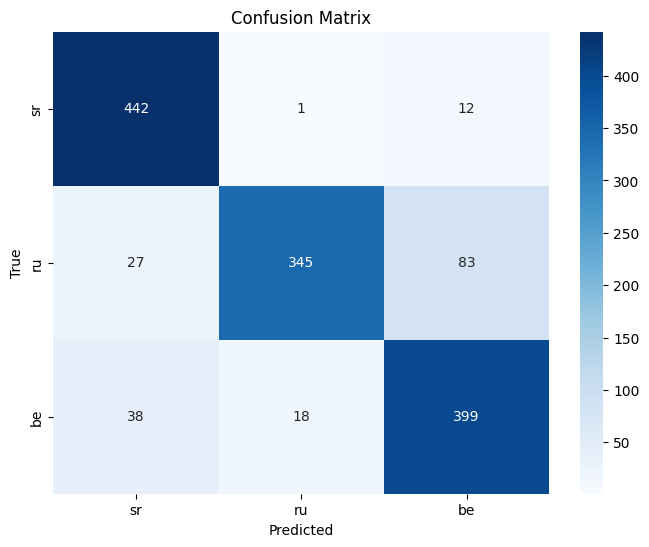

              precision    recall  f1-score   support

          sr       0.87      0.97      0.92       455
          ru       0.95      0.76      0.84       455
          be       0.81      0.88      0.84       455

    accuracy                           0.87      1365
   macro avg       0.88      0.87      0.87      1365
weighted avg       0.88      0.87      0.87      1365



In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_loader = brain.make_dataloader(test_data, stage=sb.Stage.TEST)

all_preds = []
all_labels = []

for batch in test_loader:
    # Manually move tensors to device
    wavs = batch['sig'][0].to(device)
    lengths = batch['sig'][1].to(device)
    labels = batch['lang_encoded'].to(device)

    # Forward pass manually
    feats = brain.modules.compute_STFT(wavs)
    feats = brain.modules.compute_fbanks(feats)
    feats = brain.modules.normalize(feats, lengths)
    feats = feats.transpose(1, 2)
    feats = feats.mean(dim=-1)

    embeddings = brain.modules.embedding_model(feats)
    outputs = brain.modules.classifier(embeddings)

    predicted = outputs.argmax(dim=-1).cpu().numpy()
    gold = labels.cpu().numpy()

    all_preds.extend(predicted)
    all_labels.extend(gold)

label_encoder = {
    0: "sr",
    1: "ru",
    2: "be"
}
labels_list = [label_encoder[i] for i in sorted(label_encoder)]

# Plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels_list, yticklabels=labels_list)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print precision, recall, F1
print(classification_report(all_labels, all_preds, target_names=labels_list))


## Visualisation wit t-sne

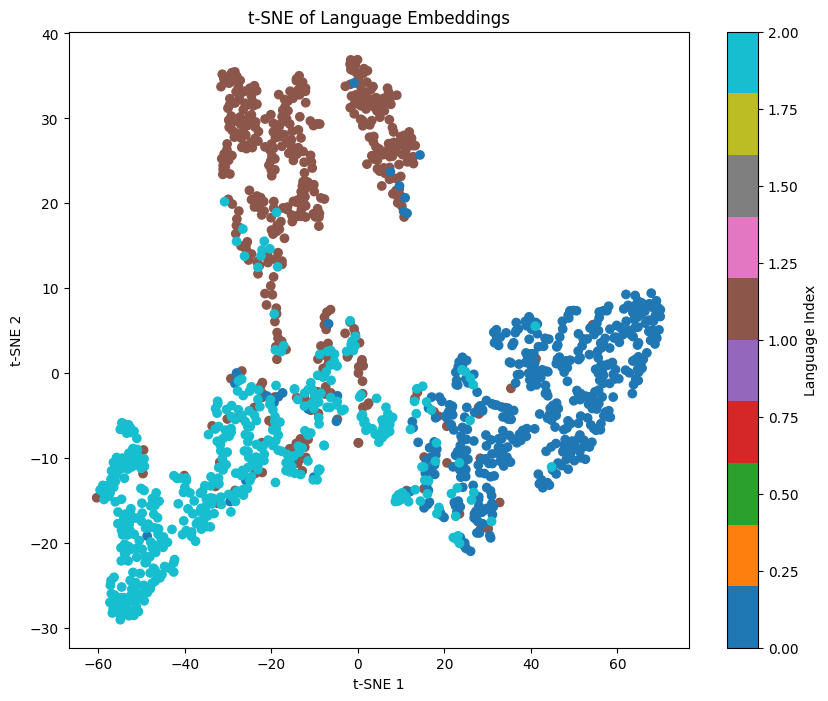

In [ ]:

brain.modules.eval()

device = brain.device
batch_size = 8


valid_loader = sb.dataio.dataloader.make_dataloader(valid_data, batch_size=batch_size, shuffle=False)

all_embeddings = []
all_labels = []

with torch.no_grad():
    for batch in valid_loader:
        batch = batch.to(device)
        wavs = batch.sig.data

        feats = brain.modules.compute_STFT(wavs)
        feats = brain.modules.compute_fbanks(feats)
        feats = brain.modules.normalize(feats, batch.sig.lengths)
        feats = feats.transpose(1, 2)
        feats = feats.mean(dim=-1)

        embeddings = brain.modules.embedding_model(feats)

        all_embeddings.append(embeddings.cpu())
        all_labels.extend(batch.lang_encoded.tolist())

# Stack and run t-SNE
all_embeddings = torch.cat(all_embeddings).numpy()
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(all_embeddings)

# Plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=all_labels, cmap='tab10')
plt.colorbar(scatter, label='Language Index')
plt.title("t-SNE of Language Embeddings")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()
